# Anomaly Comparison of Cisco Webex Data

In [1]:
import pickle
import random
import luminol
import datetime
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adtk.visualization import plot
from adtk.detector import PersistAD
from adtk.detector import SeasonalAD
from adtk.data import validate_series
from adtk.detector import LevelShiftAD
from adtk.detector import OutlierDetector
from adtk.detector import VolatilityShiftAD
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from luminol.anomaly_detector import AnomalyDetector
warnings.filterwarnings('ignore')

# Method 1(Mean Absolute deviation(MAD))

In [16]:
def preprocesMADdata(path, metric):
    df = pd.read_csv(path)
    df['date'] = 0
    for i in range(len(df.timestamps)):
        df['date'][i] = datetime.datetime.fromtimestamp(df.timestamps[i]/1000.0).strftime('%Y-%m-%d')
    try:
        df.drop(columns = ['Unnamed: 0', 'datastore', 'timestamps'], inplace = True)
    except:
        df.drop(columns = ['Unnamed: 0', 'timestamps'], inplace = True)
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date',inplace=True)
    df.drop(columns = [i for i in df.columns if i != metric and i != 'timestamps'], inplace = True)
    return df

def madBasedAnomalyDetector(df, metric, thresh=3):
    median = np.median(df[metric])
    df['deviation'] = df[metric] - median
    df['absDeviation'] = np.abs(df['deviation'])
    med_abs_deviation = np.median(df['absDeviation'])
    df['z_score'] = df['deviation'] / med_abs_deviation
    df['positive_anomaly'] = df['z_score'] > thresh
    df['negative_anomaly'] = df['z_score'] < -thresh
    df.drop(columns = ['deviation', 'absDeviation'], inplace=True)
    return df

def predictAndPlotAnomaliesUsingMad(path, metric, thresh, fromDate, toDate):
    colors = ['blue', 'red', 'magenta', 'black', 'cyan', 'indigo']
    random.shuffle(colors)
    df = preprocesData(path, metric)
    df = df[((df.index > fromDate) & (df.index < toDate))]
    df[metric] = df[metric]/(max(df[metric]))
    df = madBasedAnomalyDetector(df, metric, thresh=thresh)
    plt.figure(figsize=(25, 8))
    plt.plot(df.index, df[metric], color = 'blue', label = metric, marker='x')
    plt.scatter(df.index[df.positive_anomaly == 1], df[metric][df.positive_anomaly == 1], color = 'black', label = 'positive_anomaly')
    plt.scatter(df.index[df.negative_anomaly == 1], df[metric][df.negative_anomaly == 1], color = 'red', label = 'negative_anomaly')
    plt.title(metric, fontsize=20)
    plt.ylabel(metric, fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.legend()
    plt.show()

# Results from MAD

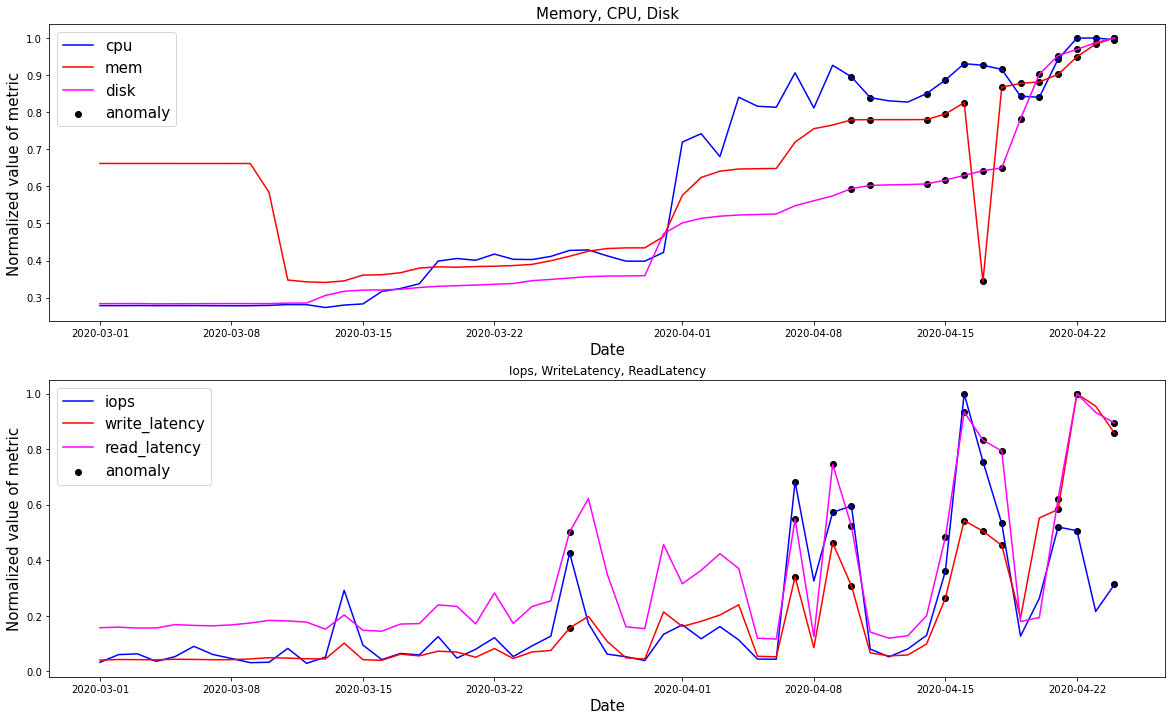

In [18]:
metrics = ['cpu', 'mem', 'disk', 'iops', 'write_latency', 'read_latency']
path1 = '../Time Series Predcition/automation/AMS01-TVPP1-CloudCenter-Cluster.csv'
path2 = '../Anomaly Detection/Data/ams01-tvpp1-sc03-cloudcenter-02.csv'
fromDate = '2020-02-29'
toDate = '2020-04-25'
colors = ['blue', 'red', 'magenta', 'black', 'cyan', 'indigo', 'coral', 'aqua', 'salmon', 'tomato', 'orchid', 'greenyellow', 'preu', 'orangered', 'limegreen', 'darkgreen', 'steelblue', 'navy']

df_list = []
thresh1 = 3
plt.figure(figsize=(20, 12))
plt.subplot(211)
for i in range(3):
    df = preprocesMADdata(path1, metrics[i])
    df = df[((df.index > fromDate) & (df.index < toDate))]
    df[metrics[i]] = df[metrics[i]]/(max(df[metrics[i]]))
    df = madBasedAnomalyDetector(df, metrics[i], thresh=thresh1)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].positive_anomaly[i] == 1) or (df_list[0][1].negative_anomaly[i] == 1) 
    b = (df_list[1][1].positive_anomaly[i] == 1) or (df_list[1][1].negative_anomaly[i] == 1)
    c = (df_list[2][1].positive_anomaly[i] == 1) or (df_list[2][1].negative_anomaly[i] == 1)
    if(a == 1 and b == 1) or (b == 1 and c == 1) or (c == 1 and a == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0
    
labels, i = [], 0
for metric, df in df_list:
    plt.plot(df.index, df[metric], color = colors[i], label = metric)
    plt.scatter(df.index[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=15)
plt.title('Memory, CPU, Disk', fontsize=15)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels = labels, fontsize=15)


df_list = []
thresh2 = 3
for i in range(3, len(metrics)):
    df = preprocesData(path2, metrics[i])
    df = df[((df.index > fromDate) & (df.index < toDate))]
    df[metrics[i]] = df[metrics[i]]/(max(df[metrics[i]]))
    df = madBasedAnomalyDetector(df, metrics[i], thresh=thresh2)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].positive_anomaly[i] == 1) or (df_list[0][1].negative_anomaly[i] == 1) 
    b = (df_list[1][1].positive_anomaly[i] == 1) or (df_list[1][1].negative_anomaly[i] == 1)
    c = (df_list[2][1].positive_anomaly[i] == 1) or (df_list[2][1].negative_anomaly[i] == 1)
    if(a == 1 and c == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0

labels, i = [], 0
plt.subplot(212)
for metric, df in df_list:
    plt.plot(df.index, df[metric], color = colors[i])
    plt.scatter(df.index[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=15)
plt.title('Iops, WriteLatency, ReadLatency', fontsize=12)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)
plt.show()

# Method 2(Isolation forest(Unsupervised Learning))

In [19]:
def createModelAndPredict(df, metric, estimators, perAnomalies=0.2):
    clf = IsolationForest(n_estimators=estimators, max_samples='auto', contamination=perAnomalies, max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    clf.fit(np.array(df[metric]).reshape(-1, 1))
    pred = clf.predict(np.array(df[metric]).reshape(-1, 1))
    return clf, pred

def classifyAnomalies(df, metric):
    df['metric_name'] = metric
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df
    
def predictAnomaliesUsingForest(path, metric, estimators, perAnomalies):
    df = pd.read_csv(path)
    df['date'] = 0
    for i in range(len(df.timestamps)):
        df['date'][i] = (datetime.datetime.fromtimestamp(df.timestamps[i]/1000.0).strftime('%Y-%m-%d'))
    try:
        df.drop(columns = ['Unnamed: 0', 'datastore', 'timestamps'], inplace = True)
    except:
        df.drop(columns = ['Unnamed: 0', 'timestamps'], inplace = True)
    df[metric] = df[metric]/(max(df[metric]))
    clf, pred = createModelAndPredict(df, metric, estimators, perAnomalies)
    test_df = pd.DataFrame()
    test_df['date'] = df.date
    test_df[metric] = df[metric]
    test_df['score'] = clf.decision_function(np.array(df[metric]).reshape(-1, 1))
    test_df['anomaly'] = pred
    outliers = test_df.loc[test_df['anomaly']==-1]
    outlier_index = list(outliers.index)
    test_df = classifyAnomalies(test_df, metric)    
    return test_df

# Results from Isolation Forest

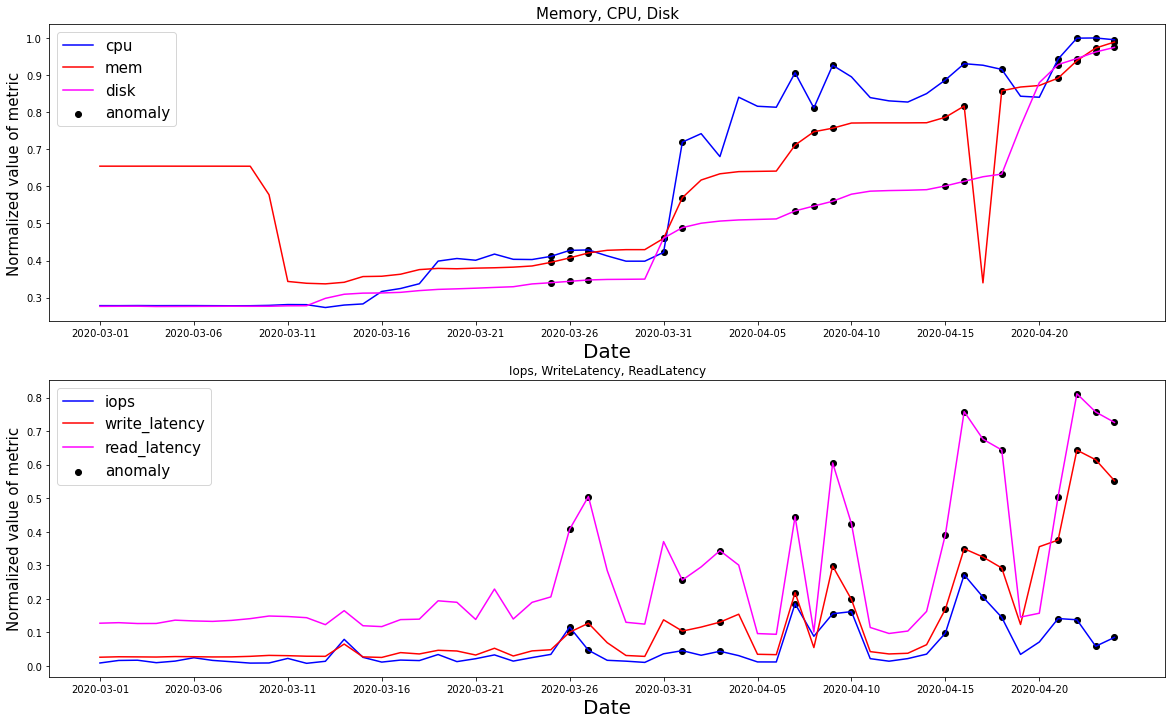

In [20]:
metrics = ['cpu', 'mem', 'disk', 'iops', 'write_latency', 'read_latency']
path1 = '../Time Series Predcition/automation/AMS01-TVPP1-CloudCenter-Cluster.csv'
path2 = '../Anomaly Detection/Data/ams01-tvpp1-sc03-cloudcenter-02.csv'
fromDate = '2020-02-29'
toDate = '2020-04-25'
colors = ['blue', 'red', 'magenta', 'black', 'cyan', 'indigo', 'coral', 'aqua', 'salmon', 'tomato', 'orchid', 'greenyellow', 'preu', 'orangered', 'limegreen', 'darkgreen', 'steelblue', 'navy']

df_list = []
for i in range(3):
    df = predictAnomaliesUsingForest(path1, metrics[i], 200, 0.15)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].anomaly_class[i] == 2) or (df_list[0][1].anomaly_class[i] == 2) 
    b = (df_list[1][1].anomaly_class[i] == 2) or (df_list[1][1].anomaly_class[i] == 2)
    c = (df_list[2][1].anomaly_class[i] == 2) or (df_list[2][1].anomaly_class[i] == 2)
    if(a == 1 and b == 1 and c == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0
    
labels, i = [], 0
plt.figure(figsize=(20, 12))

plt.subplot(211)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.xticks([i for i in range(len(df)) if i%5==0], fontsize = 10)
plt.title('Memory, CPU, Disk', fontsize=15)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)


df_list = []
for i in range(3, len(metrics)):
    df = predictAnomaliesUsingForest(path2, metrics[i], 200, 0.2)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].anomaly_class[i] == 2) or (df_list[0][1].anomaly_class[i] == 2) 
    b = (df_list[1][1].anomaly_class[i] == 2) or (df_list[1][1].anomaly_class[i] == 2)
    c = (df_list[2][1].anomaly_class[i] == 2) or (df_list[2][1].anomaly_class[i] == 2)
    if(a == 1 and b == 1 and c == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0
    
labels, i = [], 0
plt.subplot(212)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.xticks([i for i in range(len(df)) if i%5==0], fontsize = 10)
plt.title('Iops, WriteLatency, ReadLatency', fontsize=12)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)
plt.show()

# Method 3(Using Luminol(open source library by LinkedIn)

In [22]:
def preprocesLuminolData(path, metric):
    df = pd.read_csv(path)
    df[metric] = df[metric]/(max(df[metric]))
    ts = df.copy()
    ts.drop(columns = [column for column in df.columns if column != metric and column != 'timestamps'], inplace=True)
    df['date'] = 0
    for i in range(len(df.timestamps)):
        df['date'][i] = datetime.datetime.fromtimestamp(df.timestamps[i]/1000.0).strftime('%Y-%m-%d')
    try:
        df.drop(columns = ['Unnamed: 0', 'datastore'], inplace = True)
    except:
        df.drop(columns = ['Unnamed: 0'], inplace = True)
    df['date']=pd.to_datetime(df['date'])
    df.drop(columns = [i for i in df.columns if i != metric and i != 'date'], inplace = True)
    dict_ts = {}
    for i in range(len(ts)):
        dict_ts[ts['timestamps'][i]] = ts[metric][i]
    return df, dict_ts

def luminol(ts):
    my_detector = AnomalyDetector(ts)
    score = my_detector.get_all_scores()
    anomalies = my_detector.get_anomalies()
    frm, to = [], []
    for a in anomalies:
        fromDate, toDate = a.get_time_window()
        fromDate, toDate = datetime.datetime.fromtimestamp(fromDate/1000).strftime('%Y-%m-%d'), datetime.datetime.fromtimestamp(toDate/1000).strftime('%Y-%m-%d')
        frm.append(fromDate)
        to.append(toDate)
    return score, frm, to

def predictUsingAnomaliesUsingLuminol(path, metric, threshold=0):
    df, ts = preprocesLuminolData(path, metric)
    score, frm, to = luminol(ts)
    if threshold:
        sc = []
        for _, value in score.iteritems():
            sc.append(value)
        df['score'] = sc
        df['anomaly'] = df.score > threshold
    else:
        df['anomaly'] = 0
        for i in range(len(frm)):
            start_date = frm[i]
            end_date = to[i]
            mask = (df.date >= start_date) & (df.date <= end_date)
            df['anomaly'][mask] = 1
    return df

# Results from Luminol

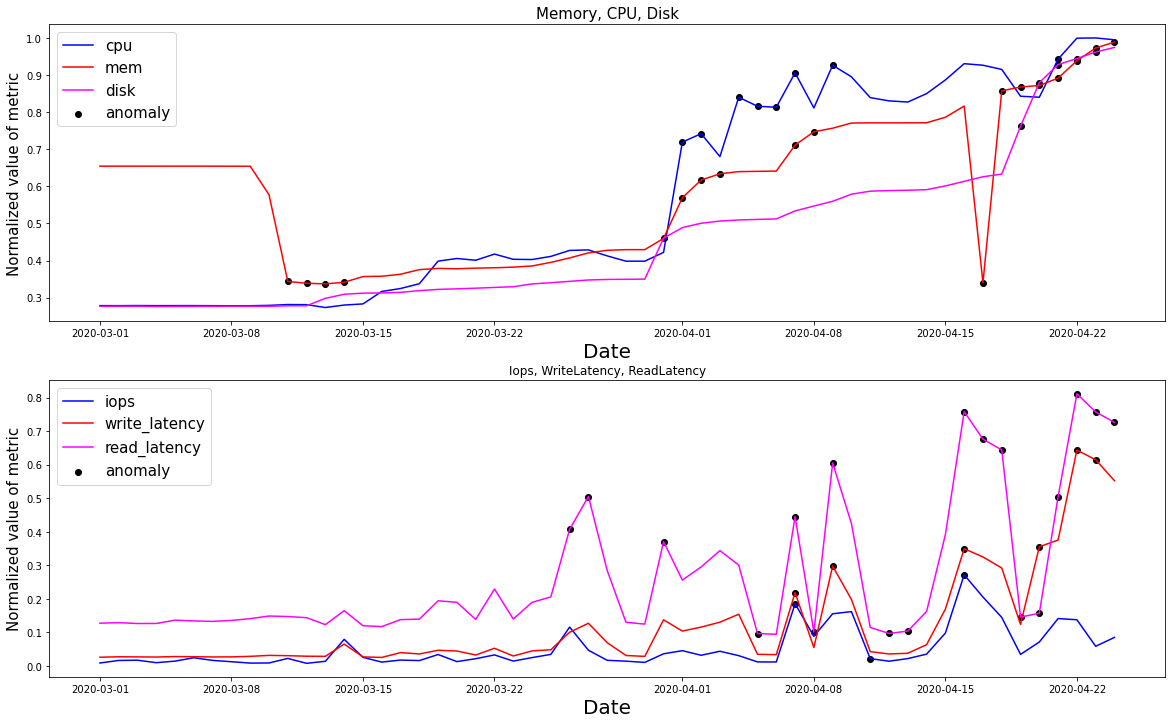

In [23]:
metrics = ['cpu', 'mem', 'disk', 'iops', 'write_latency', 'read_latency']
path1 = '../Time Series Predcition/automation/AMS01-TVPP1-CloudCenter-Cluster.csv'
path2 = '../Anomaly Detection/Data/ams01-tvpp1-sc03-cloudcenter-02.csv'
fromDate = '2020-02-29'
toDate = '2020-04-25'
colors = ['blue', 'red', 'magenta', 'black', 'cyan', 'indigo', 'coral', 'aqua', 'salmon', 'tomato', 'orchid', 'greenyellow', 'preu', 'orangered', 'limegreen', 'darkgreen', 'steelblue', 'navy']

df_list = []
thresh1 = 1
for i in range(3):
    df = predictUsingAnomaliesUsingLuminol(path1, metrics[i], thresh1)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

labels, i = [], 0
plt.figure(figsize=(20, 12))

plt.subplot(211)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.title('Memory, CPU, Disk', fontsize=15)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)


df_list = []
thresh2 = 1
for i in range(3, len(metrics)):
    df = predictUsingAnomaliesUsingLuminol(path2, metrics[i], thresh2)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

labels, i = [], 0
plt.subplot(212)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.title('Iops, WriteLatency, ReadLatency', fontsize=12)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)
plt.show()

# Result as whole picture

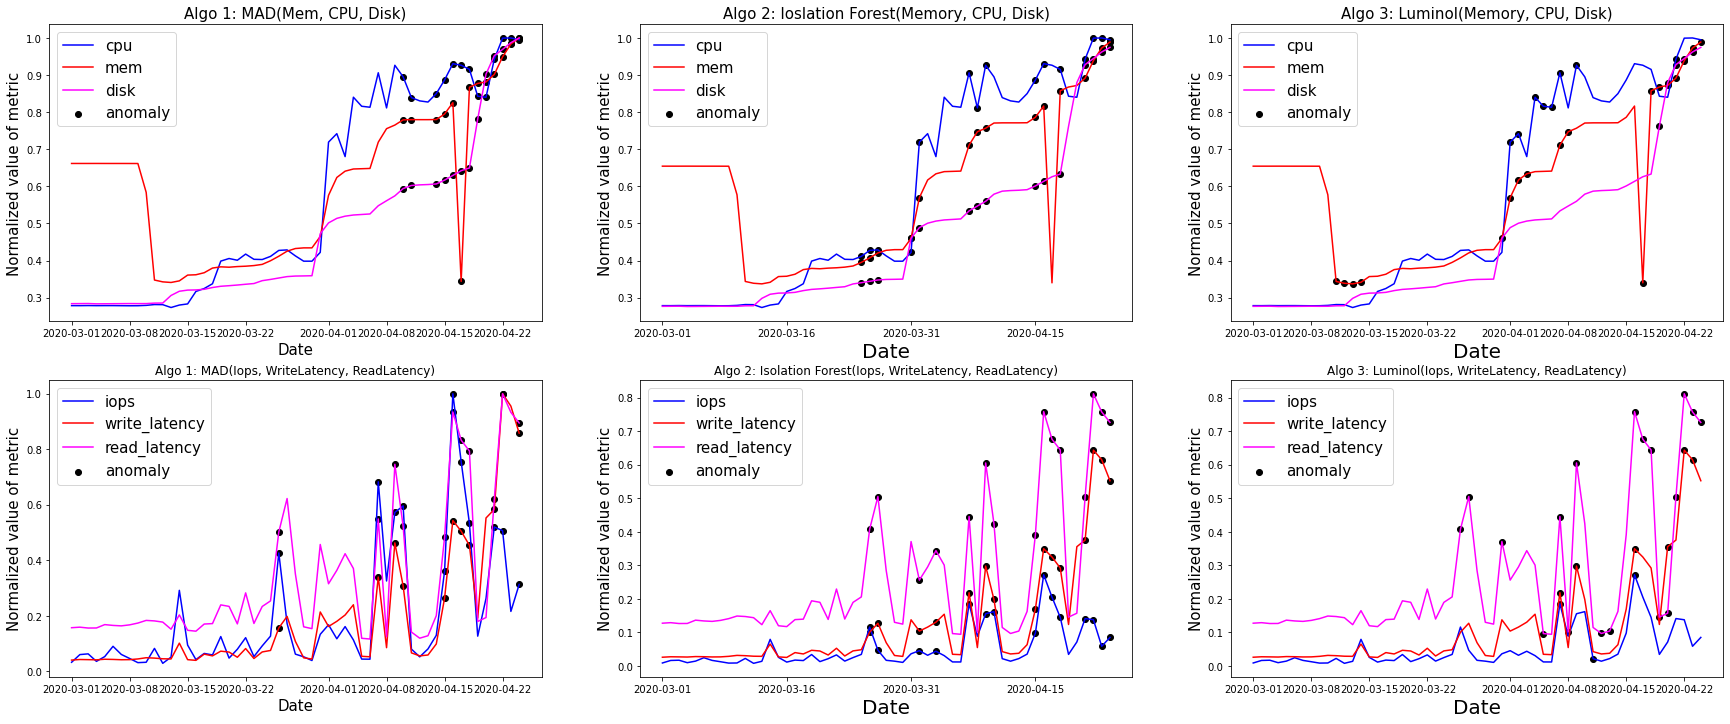

In [26]:
metrics = ['cpu', 'mem', 'disk', 'iops', 'write_latency', 'read_latency']
path1 = '../Time Series Predcition/automation/AMS01-TVPP1-CloudCenter-Cluster.csv'
path2 = '../Anomaly Detection/Data/ams01-tvpp1-sc03-cloudcenter-02.csv'
fromDate = '2020-02-29'
toDate = '2020-04-25'
colors = ['blue', 'red', 'magenta', 'black', 'cyan', 'indigo', 'coral', 'aqua', 'salmon', 'tomato', 'orchid', 'greenyellow', 'preu', 'orangered', 'limegreen', 'darkgreen', 'steelblue', 'navy']

df_list = []
thresh1 = 3
plt.figure(figsize=(30, 12))
plt.subplot(231)
for i in range(3):
    df = preprocesMADdata(path1, metrics[i])
    df = df[((df.index > fromDate) & (df.index < toDate))]
    df[metrics[i]] = df[metrics[i]]/(max(df[metrics[i]]))
    df = madBasedAnomalyDetector(df, metrics[i], thresh=thresh1)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].positive_anomaly[i] == 1) or (df_list[0][1].negative_anomaly[i] == 1) 
    b = (df_list[1][1].positive_anomaly[i] == 1) or (df_list[1][1].negative_anomaly[i] == 1)
    c = (df_list[2][1].positive_anomaly[i] == 1) or (df_list[2][1].negative_anomaly[i] == 1)
    if(a == 1 and b == 1) or (b == 1 and c == 1) or (c == 1 and a == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0
    
labels, i = [], 0
for metric, df in df_list:
    plt.plot(df.index, df[metric], color = colors[i], label = metric)
    plt.scatter(df.index[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=15)
plt.title('Algo 1: MAD(Mem, CPU, Disk)', fontsize=15)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels = labels, fontsize=15)


df_list = []
thresh2 = 3
for i in range(3, len(metrics)):
    df = preprocesData(path2, metrics[i])
    df = df[((df.index > fromDate) & (df.index < toDate))]
    df[metrics[i]] = df[metrics[i]]/(max(df[metrics[i]]))
    df = madBasedAnomalyDetector(df, metrics[i], thresh=thresh2)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].positive_anomaly[i] == 1) or (df_list[0][1].negative_anomaly[i] == 1) 
    b = (df_list[1][1].positive_anomaly[i] == 1) or (df_list[1][1].negative_anomaly[i] == 1)
    c = (df_list[2][1].positive_anomaly[i] == 1) or (df_list[2][1].negative_anomaly[i] == 1)
    if(a == 1 and c == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0

labels, i = [], 0
plt.subplot(234)
for metric, df in df_list:
    plt.plot(df.index, df[metric], color = colors[i])
    plt.scatter(df.index[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=15)
plt.title('Algo 1: MAD(Iops, WriteLatency, ReadLatency)', fontsize=12)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)




df_list = []
for i in range(3):
    df = predictAnomaliesUsingForest(path1, metrics[i], 200, 0.15)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].anomaly_class[i] == 2) or (df_list[0][1].anomaly_class[i] == 2) 
    b = (df_list[1][1].anomaly_class[i] == 2) or (df_list[1][1].anomaly_class[i] == 2)
    c = (df_list[2][1].anomaly_class[i] == 2) or (df_list[2][1].anomaly_class[i] == 2)
    if(a == 1 and b == 1 and c == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0
    
labels, i = [], 0

plt.subplot(232)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.xticks([i for i in range(len(df)) if i%15==0], fontsize = 10)
plt.title('Algo 2: Ioslation Forest(Memory, CPU, Disk)', fontsize=15)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)


df_list = []
for i in range(3, len(metrics)):
    df = predictAnomaliesUsingForest(path2, metrics[i], 200, 0.2)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

df_list[0][1]['anomaly'] = 0
df_list[1][1]['anomaly'] = 0
df_list[2][1]['anomaly'] = 0
for i in range(len(df)):
    a = (df_list[0][1].anomaly_class[i] == 2) or (df_list[0][1].anomaly_class[i] == 2) 
    b = (df_list[1][1].anomaly_class[i] == 2) or (df_list[1][1].anomaly_class[i] == 2)
    c = (df_list[2][1].anomaly_class[i] == 2) or (df_list[2][1].anomaly_class[i] == 2)
    if(a == 1 and b == 1 and c == 1):
        df_list[0][1]['anomaly'][i] = 1
        df_list[1][1]['anomaly'][i] = 1
        df_list[2][1]['anomaly'][i] = 1
    else:
        df_list[0][1]['anomaly'][i] = 0
        df_list[1][1]['anomaly'][i] = 0
        df_list[2][1]['anomaly'][i] = 0
    
labels, i = [], 0
plt.subplot(235)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.xticks([i for i in range(len(df)) if i%15==0], fontsize = 10)
plt.title('Algo 2: Isolation Forest(Iops, WriteLatency, ReadLatency)', fontsize=12)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)

df_list = []
thresh1 = 1
for i in range(3):
    df = predictUsingAnomaliesUsingLuminol(path1, metrics[i], thresh1)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

labels, i = [], 0
plt.subplot(233)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.title('Algo 3: Luminol(Memory, CPU, Disk)', fontsize=15)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)


df_list = []
thresh2 = 1
for i in range(3, len(metrics)):
    df = predictUsingAnomaliesUsingLuminol(path2, metrics[i], thresh2)
    df = df[((df.date > fromDate) & (df.date < toDate))]
    df.reset_index(inplace=True)
    df_list.append((metrics[i], df))

labels, i = [], 0
plt.subplot(236)
for metric, df in df_list:
    plt.plot(df.date, df[metric], color = colors[i], label = metric)
    plt.scatter(df.date[df.anomaly == 1], df[metric][df.anomaly == 1], color = 'black')
    i += 1
    labels.append(metric)
labels.append('anomaly')
plt.xlabel('Date', fontsize=20)
plt.title('Algo 3: Luminol(Iops, WriteLatency, ReadLatency)', fontsize=12)
plt.ylabel('Normalized value of metric', fontsize=15)
plt.legend(labels=labels, fontsize=15)
plt.show()